# 1. LeNet-5卷积网络

假如对多神经元的模型97.37%的准确率还不满意
可以使用卷积神经网络模型LeNet-5来解决问题

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np

# 载入数据集
mnist = input_data.read_data_sets("../data/", one_hot=True)

# 显示数据集数量
print("训练集数量：", mnist.train.num_examples)
print("验证集数量：", mnist.validation.num_examples)
print("测试集数量：", mnist.test.num_examples)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
训练集数量： 55000
验证集数量： 5000
测试集数量： 10000


# 2. 数据读取

利用网上的 MNIST 数据集(http://yann.lecun.com/exdb/mnist/)获取数据集压缩文件（切勿解压）：

train-images-idx3-ubyte.gz --- 6万张28x28大小的训练数字图像

train-labels-idx1-ubyte.gz --- 6万张训练图像的数字标记

t10k-images-idx3-ubyte.gz  --- 1万张28x28大小的测试数字图像

t10k-labels-idx1-ubyte.gz  --- 1万张测试图像的数字标记

In [2]:
# 显示数据集大小
print("训练图像大小：", mnist.train.images.shape)
print("训练标签大小：", mnist.train.labels.shape)

训练图像大小： (55000, 784)
训练标签大小： (55000, 10)


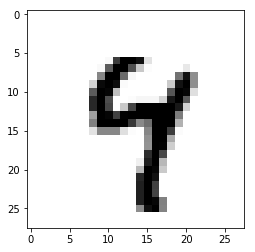

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [3]:
# 可视化图像
def plot_image(image):
    plt.imshow(image.reshape(28, 28), cmap='binary')
    plt.show()


# 可视化第二张训练图像
plot_image(mnist.train.images[2])

# 可视化第二张图像的标签
print(mnist.train.labels[2])

# 3. 构建模型

In [4]:
# 定义训练数据的占位符， x是784个像素点的特征值， y是10分类的标签值
x = tf.placeholder(tf.float32, [None, 784], name="X")
y = tf.placeholder(tf.float32, [None, 10], name="Y")

# 为了使用卷积层，需把x变成一个4d向量，其第2、第3维对应图片的宽、高，最后一维代表图片的颜色通道数
x_image = tf.reshape(x, [-1, 28, 28, 1])


# 权重W 初始化 从标准差0.1的截断正态分布中输出随机值
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


# 权重b 初始化 0.1
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


# 定义1步长的 valid卷积
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')


# 定义步长为2 大小2x2的 max pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


# 第一层卷积 每个5x5的patch中算出6个特征
W_conv1 = weight_variable([5, 5, 1, 6])
b_conv1 = bias_variable([6])

# 第一层relu激活
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# 第一层池化
h_pool1 = max_pool_2x2(h_conv1)

# 第二层卷积 每个5x5的patch中算出16个特征
W_conv2 = weight_variable([5, 5, 6, 16])
b_conv2 = bias_variable([16])

# 第二层relu激活
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

# 第二层池化
h_pool2 = max_pool_2x2(h_conv2)

# 第三层全连接
W_fc1 = weight_variable([4 * 4 * 16, 120])
b_fc1 = bias_variable([120])
h_pool2_flat = tf.reshape(h_pool2, [-1, 4 * 4 * 16])  # 重新展开
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# 第四层全连接
W_fc2 = weight_variable([120, 84])
b_fc2 = bias_variable([84])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)

# 输出层 softmax层
W_fc3 = weight_variable([84, 10])
b_fc3 = bias_variable([10])
forward = tf.matmul(h_fc2, W_fc3) + b_fc3
pred = tf.nn.softmax(forward)

train_epochs = 20  # 迭代次数
learning_rate = 1e-3  # 学习率

# 定义损失函数
with tf.name_scope("LossFunction"):
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=forward, labels=y))

Instructions for updating:
Colocations handled automatically by placer.


# 4. 训练模型

In [5]:
# Adam优化器 设置学习率和优化目标损失最小化
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function)

# 定义预测类别匹配情况
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# 定义准确率，将布尔值转化成浮点数，再求平均值
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# 每个批次的大小，每次放入的大小，每次放入 100张图片 以矩阵的方式
batch_size = 100

# 计算一共有多少个批次，数量整除大小训练出有多少批次
n_batch = mnist.train.num_examples // batch_size

sess = tf.Session()  # 建立会话
init = tf.global_variables_initializer()  # 变量初始化
sess.run(init)

for epoch in range(train_epochs):
    for batch in range(n_batch):
        xs, ys = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={x: xs, y: ys})
        # 批次训练完成之后，使用验证数据计算误差与准确率
    loss, acc = sess.run([loss_function, accuracy],
                         feed_dict={x: mnist.validation.images,
                                    y: mnist.validation.labels})
    # 显示训练信息
    print("Train Epoch", '%02d' % (epoch + 1), "Loss=", '{:.9f}'.format(loss), "Accuracy=",
          "{:.4f}".format(acc))

Train Epoch 01 Loss= 0.108200222 Accuracy= 0.9696
Train Epoch 02 Loss= 0.066758297 Accuracy= 0.9822
Train Epoch 03 Loss= 0.064959630 Accuracy= 0.9822
Train Epoch 04 Loss= 0.049632501 Accuracy= 0.9852
Train Epoch 05 Loss= 0.041107506 Accuracy= 0.9886
Train Epoch 06 Loss= 0.041755408 Accuracy= 0.9884
Train Epoch 07 Loss= 0.041898545 Accuracy= 0.9898
Train Epoch 08 Loss= 0.036958639 Accuracy= 0.9908
Train Epoch 09 Loss= 0.039780248 Accuracy= 0.9906
Train Epoch 10 Loss= 0.057369702 Accuracy= 0.9822
Train Epoch 11 Loss= 0.041729357 Accuracy= 0.9906
Train Epoch 12 Loss= 0.044323169 Accuracy= 0.9898
Train Epoch 13 Loss= 0.039810352 Accuracy= 0.9906
Train Epoch 14 Loss= 0.045707256 Accuracy= 0.9878
Train Epoch 15 Loss= 0.036656860 Accuracy= 0.9902
Train Epoch 16 Loss= 0.041974217 Accuracy= 0.9906
Train Epoch 17 Loss= 0.046835992 Accuracy= 0.9906
Train Epoch 18 Loss= 0.035773896 Accuracy= 0.9910
Train Epoch 19 Loss= 0.041715056 Accuracy= 0.9892
Train Epoch 20 Loss= 0.041373160 Accuracy= 0.9912


# 5. 评估模型

In [6]:
# 测试集上评估模型预测的准确率
accu_test = sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})
print("Test Accuracy = ", accu_test)

# 验证集上评估模型预测的准确率
accu_validation = sess.run(accuracy, feed_dict={x: mnist.validation.images, y: mnist.validation.labels})
print("Validation Accuracy = ", accu_validation)

Test Accuracy =  0.9902
Validation Accuracy =  0.9912


# 6. 模型预测

In [7]:
# 转换pred预测结果独热编码格式为数字0-9
prediction_result = sess.run(tf.argmax(pred, 1), feed_dict={x: mnist.test.images})

# # 查看第300-309张测试图片的预测结果
print(prediction_result[300:310])

[4 7 1 2 4 0 2 7 4 3]


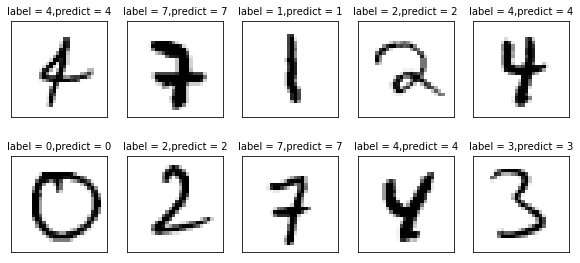

In [8]:
# 定义比对可视化函数
def plot_images_labels_prediction(images,  # 图像列表
                                  labels,  # 标签列表
                                  prediction,  # 预测值列表
                                  index,  # 开始显示的索引
                                  num=5):  # 缺省一次显示5张
    fig = plt.gcf()  # 获取当前图表，get current figure
    fig.set_size_inches(10, 12)  # 1英寸等于2.54cm

    if num > 25:  # 最多显示25张图片
        num = 25

    for i in range(0, num):
        ax = plt.subplot(5, 5, i + 1)  # 获取当前要处理的图片
        ax.imshow(np.reshape(images[index], (28, 28)), cmap='binary')  # 显示第index个图像
        title = 'label = ' + str(np.argmax(labels[index]))  # 显示标签的标题
        if len(prediction) > 0:  # 如果有预测结果的话，添加显示预测的标题
            title += ',predict = ' + str(prediction[index])
        ax.set_title(title, fontsize=10)  # 显示图上的标题
        # 不显示坐标轴
        ax.set_xticks([])
        ax.set_yticks([])
        index += 1
    plt.show()


# 可视化第300-309张测试图片的预测结果对比
plot_images_labels_prediction(mnist.test.images,
                              mnist.test.labels,
                              prediction_result,
                              300, 10)